# TO DO
Visualizations  
Preprocessing  
Complete dataset  
Split by government, media, public  
**REmoveAdditional stopwords: add_stopwords = ['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio','month','week','news','please']**

# LDA

We'll use NumPy.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import pandas as pd
# data: 20 news groups

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/ribarragi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Latent Dirichlet Allocation

We first load in 10,000 posts from the 20 Newsgroups dataset.

In [4]:
# Data preprocessing (From Elaine's)
df = pd.read_csv('../data/data_tweet.csv')


# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                                   "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
tokenizer = RegexpTokenizer(r'\w+')

# normalize pos tags
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
      return wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return wordnet.VERB
  elif nltk_tag.startswith('N'):
      return wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return wordnet.ADV
  else:         
      return None


# lemmatize each token with pos tag
def lemma_token(row):
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized

# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith(("https://", 'http://')))]))

# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [5]:
df.head(4)

,LANGUAGE,LOCATION,SENDER,MESSAGE,Impressions,NUMBER_FOLLOWERS,RETWEET_COUNT,Twitter Likes,IS_VERIFIED,HAS_URL,...,TIME,IS_IN_REPLY_TO,IS_NEWS_AGENCY,TWEET_COUNT,IS_MEDIA,IS_GOVT,IS_PEOPLE,Message_no_url,Text,T_text
0,en,USA,TurnKyBlue,RT @TristanSnell Get rid of train safety rules...,4414.0,4414.0,0.0,0.0,0.0,0.0,...,21:56:12,NaN,NaN,NaN,0,0,1,RT @TristanSnell Get rid of train safety rules...,"[rt, tristansnell, get, rid, train, safety, ru...",rt tristansnell get rid train safety rule get ...
1,en,NaN,jrbkjrbk,RT @realTuckFrumper Ohio Sues Norfolk Southern...,1011.0,1011.0,0.0,0.0,0.0,1.0,...,21:56:03,NaN,NaN,NaN,0,0,1,RT @realTuckFrumper Ohio Sues Norfolk Southern...,"[rt, realtuckfrumper, ohio, sue, norfolk, sout...",rt realtuckfrumper ohio sue norfolk southern t...
2,en,NaN,camoxendale,RT @SenJeffMerkley We need accountability from...,990.0,990.0,0.0,0.0,0.0,0.0,...,21:55:12,NaN,NaN,NaN,0,0,1,RT @SenJeffMerkley We need accountability from...,"[rt, senjeffmerkley, need, accountability, nor...",rt senjeffmerkley need accountability norfolk ...
3,en,NaN,strongfemchar,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,64.0,64.0,0.0,0.0,0.0,0.0,...,21:54:42,NaN,NaN,NaN,0,0,1,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,"[rt, nicksortor, break, state, ohio, sue, norf...",rt nicksortor break state ohio sue norfolk sou...


In [7]:
len(df)

85220

In [3]:
# tweet_data = pd.read_csv('../data/data_tweet.csv')
# tweet_data = [i for i in tweet_data.MESSAGE]
# len(tweet_data)

85220

In [8]:
import random
sample_size = 10000
random.seed(1)
# We will use a random sample of 10k tweets to test
idx_sample = random.sample(range(len(df.T_text)), sample_size)
# sample_data is a list of strings, each string is a tweet. ssample_Data is length 10k
sample_data = [df.T_text[i] for i in idx_sample]

In [10]:
len(sample_data)

10000

We now fit a `CountVectorizer` model that will compute, for each post, what its raw word count histograms are (the "term frequencies" we saw in week 1).

The output of the following cell is the term-frequencies matrix, where rows index different posts/text documents, and columns index 1000 different vocabulary words. A note about the arguments to `CountVectorizer`:

- `max_df`: we only keep words that appear in at most this fraction of the documents
- `min_df`: we only keep words that appear in at least this many documents
- `stop_words`: whether to remove stop words
- `max_features`: among words that don't get removed due to the above 3 arguments, we keep the top `max_features` number of most frequently occuring words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# We could cap the size of the vocab to vocab_size, right no, we wont
vocab_size = 1000


# CountVectorizer does tokenization
# min_df: words in less than 2 documents, we throw it away
# max_df filters for the words were keeping track of:words that show up in more than 95% of document, we throw away, not
# semantically interesting; we can use it as an int (50: then every word appearing in omre than 50 docs, goes away)

# max_features: here is 1,000: after I do the max_df, min_df and stopwords filetrs, I look at how many words I have left: if its greater than
# max_features, I only keep the most popular. BUT, if the words left after the 3 filters is less than max_features, then it will be ignored. 
# document frequency (df) means number of documents a word appears in

# min_df = 2
# max_df = 0.95

# tf_vectorizer = CountVectorizer(max_df=0.95,
#                                 min_df=2,
#                                 stop_words='english',
#                                 max_features=vocab_size)

tf_vectorizer = CountVectorizer(stop_words='english')

# tf: term frequency vectorizer

# the fitting is learning the vocabulary: goes thru all the data and know the words it needs to keep track of
# transform: Ive done the fitting, Ill go back to data points and convert each one into a feat vector representation using the vocab i learnt during fitting
tf_fit = tf_vectorizer.fit(sample_data)
tf = tf_vectorizer.fit_transform(sample_data)


In [12]:
tf.toarray()[0, 1]

0

In [13]:
# size of the matrix (documents, words)
tf.toarray().shape

(10000, 14489)

In [14]:
# seems like the highest term-doc freq is 9
max_freq = np.unique(tf.toarray().flatten()).max()
max_freq

7

In [15]:
# Just for curiosity, I want to know which doc / word combination has highest valeus
max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
max_freq_idx

[156, 5354]

In [16]:
max_freq_doc, max_freq_word = max_freq_idx

In [17]:
sample_data[max_freq_doc]

'breitbartnews ohio gop gov gop senate gop house norfolk southern train derail gop county ceo huge gop trump donor gop gov set toxin fire gop gov call biden back day delay declare disaster ask feed help'

In [18]:
# to print out the vocabulary in the doc-word freq matrix
tf_vectorizer.get_feature_names_out()[max_freq_word]

# In this case, its https because of a series of links, we should discard urls

'gop'

In [19]:
tf.toarray().sum(axis  = 0)

array([ 14, 160,   1, ...,   1,   1,   1])

In [21]:
(tf[:, tf_fit.vocabulary_['gop']].toarray().flatten() > 0).sum()

176

In [22]:
tf_fit.vocabulary_['gop']  #index for just
tf[:, tf_fit.vocabulary_['gop']].toarray() # all rows just this one column


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [23]:

(tf[:, tf_vectorizer.vocabulary_['gop']].toarray().flatten() > 0).sum() # this gives you

176

In [17]:
# tf_vectorizer.vocabulary_ # gives youi index of each word kept in the tf table

We can verify that there are 10,000 rows (corresponding to posts), and 1000 columns (corresponding to words).

In [24]:
tf.shape
# 10,000 posts
# 1,000 words


(10000, 14489)

A note about the `tf` matrix: this actually is stored as what's called a sparse matrix (rather than a 2D NumPy array that you're more familiar with). The reason is that often these matrices are really large and the vast majority of entries are 0, so it's possible to save space by not storing where the 0's are.

In [19]:
type(tf)
# this is not a numpy array, but a scipy matrix: keep only the non zero entries of the matrix: stored as a sparse matrix, or ill get a memory error

scipy.sparse._csr.csr_matrix

 To convert `tf` to a 2D NumPy table, you can run `tf.toarray()` (this does not modify the original `tf` variable).

In [20]:
type(tf.toarray())
# here I can covnert into array: a dense matrix, because the shape is not that large

numpy.ndarray

In [25]:
tf.toarray().shape

(10000, 14489)

We can figure out what words the different columns correspond to by using the `get_feature_names()` function; the output is in the same order as the column indices. In particular, we can index into the following list (i.e., so given a column index, we can figure out which word it corresponds to).

In [26]:
print(tf_vectorizer.get_feature_names())
# this will print out the vocabulary, here 1,000 words, sorted alphabetically

['00', '000', '000ppm', '00am', '00pm', '01', '01iota', '02', '025ot0mkxw', '03', '03feb', '04', '044', '05', '06', '07', '08mamakitti08', '09', '0ddette', '0iy7kotfpf', '0keren9', '0llmy8vtha', '0xalaric', '10', '100', '1000', '1000s', '100ppm', '100s', '101', '101dalmatianstreet', '102', '103', '104', '1063word', '107', '109', '10a', '10am', '10b', '10bn', '10k', '10mi', '10mm_404', '10s', '10th', '10tv', '10yrs', '11', '1100', '111', '112', '112michelle112', '114th', '115', '115k', '116', '11llotus', '11m', '11th', '12', '120', '123info', '127', '129', '1290', '12m', '12p', '12th', '13', '132', '135', '137', '13molon', '13nvestr13', '13th', '14', '140', '141', '1480whbc', '149', '14th', '15', '150', '151', '159', '15th', '16', '164', '16waptnews', '17', '1700', '175f', '1776eagles', '177_mit', '17th', '18', '180', '1819news', '1851center', '18er1rwt9v', '18th', '18分钟开始曝光地下钱庄https', '19', '1900s', '1903', '191', '1919', '1960', '1960s', '1961mcruzer', '1970', '1974', '1978', '1982', 

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We can also go in reverse: given a word, we can figure out which column index it corresponds to. To do this, we use the `vocabulary_` attribute.

In [27]:
tf_vectorizer.vocabulary_['car']
# .vocabulary_ get the word index in the vocabulary
# IN OTHER WORDS: what column do I have to look at to find the word car

2161

We can figure out what the raw counts are for the 0-th post as follows.

In [24]:
tf.toarray().shape

(10000, 24428)

In [25]:
tf[0].toarray()

# I can index in to the zeroeth row of the matrix and convert into an array, I am anazlizing just the zeroeth row:
# feature vector representation for the zeroeth document: 
# We should be able to write code to know what word corresponds each non zero number there

# tf_vectorizer.get_feature_names_out()[(tf[0].toarray() != 0)[0]] # LIKE THIS!

# run a for loop that goes thru the entries, and check to which indeces this corresponds in the vocabulary

array([[0, 0, 0, ..., 0, 0, 0]])

We now fit an LDA model to the data.

In [28]:
# Now LDA. This will take a while ong

num_topics = 5

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=0)

The fitting procedure determines the every topic's distribution over words; this information is stored in the `components_` attribute. There's a catch: we actually have to normalize to get the probability distributions (without this normalization, instead what the model has are pseudocounts for how often different words appear per topic).

In [29]:
lda.components_.shape
# The shaope of this is 16 by 1000, 10 topics and 1000 words
# These are not probability distributions yet

(5, 14489)

In [30]:
# If we access: sum ACROSS COLUMNS (get rid of columns), I get 6 numbers: a sum for each row.
# They dont sum uop to 1, because not probability distributions

# .components_ is a raw count histogram, but why are there fractions?
# Because of how it works: when it estimates how much a word belongs to a topic it does a prob assignment, not a deterministic assignment.
lda.components_.sum(axis=1)

array([51899.95839, 11396.8621 , 16871.84612, 48435.49054, 35979.84285])

In [31]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
# We can get the proba distributions: take each row and divide by sum, then we get what was in the purple box in the lecture slide:
# 

In [32]:
topic_word_distributions.shape

(5, 14489)

We can verify that each topic's word distribution sums to 1.

In [33]:
topic_word_distributions.sum(axis=1)
# then we have distributions: every row sums to 1

array([1., 1., 1., 1., 1.])

We can also print out what the probabilities for the different words are for a specific topic. This isn't very easy to interpret.

In [34]:
print(topic_word_distributions[0])
# lets look at 0th topic, it is saying that the 0th word appears 0.00011, word 1 appears with prob 0.00191
# Lets view the data differently to interpret

[0.00023 0.0022  0.      ... 0.00002 0.      0.     ]


Instead, usually people do something like looking at the most probable words per topic, and try to use these words to interpret what the different topics correspond to.

In [35]:
# we can sort the probability by big to small
# for each topic, listing top 20 most popular words (by probability)

num_top_words = 20

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        # This is the interesting part: take the topic_word_distributions only for the topic_idxth topic, and get the indexes sorted from highest to lowest
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        # then for the range 0,num_words, print the vocab of each of the words and its entry in the topic_word_distribution matrix
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
train : 0.04494796296967448
palestine : 0.04470426488558929
east : 0.04454425758823682
ohio : 0.037049605831371714
derailment : 0.03501928102871137
rt : 0.0207684552577111
chemical : 0.018875588003593884
toxic : 0.015051674372399373
norfolk : 0.012525607648177244
southern : 0.01209449809493939
resident : 0.011046786747354249
derail : 0.00802365010289283
say : 0.00733496975123015
town : 0.00542972290627591
disaster : 0.005035643685756647
hazardous : 0.004808357960385085
crash : 0.004788801274217134
carry : 0.00463808666188525
report : 0.00441152874038668
release : 0.004381380233251088

[Topic 1]
rt : 0.01102388375122378
pay : 0.011001321849111987
million : 0.008807643973099879
norfolk : 0.007865056332287507
victim : 0.007738504073669798
care : 0.007245150538977711
southern : 0.007053654571517336
say : 0.006973790838839484
billion : 0.006761572140243558
need : 0.006665513689466389
people : 0.0065

We can use the `transform()` function to figure out for each document, what fraction of it is explained by each of the topics.

In [1]:
# consider removing:
terms_remove = ['train', 'https', 'rt', 'palestine', 'east', 'ohio', 'norfolk', 'southern']

In [106]:
doc_topic_matrix = lda.transform(tf)
# Ill get a low dimensional version of the data, the document topic matrix (10, 10)
# each of the 10,000 represented as a distribution over 10 different topics

In [107]:
doc_topic_matrix.shape

(10000, 10)

In [108]:
# The topic distribution of the 0th document is very small except for 0.96288 fior index 7
# We saw from above, topic 7 is about religion, and we can check that document 0 is about religion
doc_topic_matrix[0]


# Note: for GMM when you do the .predict, itll give you k probabilites that sum to 1. 
# predict_proba of GMM 
# here: ... gives you a proba distr:
# INTERPRETARATION DIFFERENT

# FOR LDA: document can consist of a bunch of words, and different fraction of the words are truly in different topics: we get mixed membership, words are allowed to e in different topics
# GMM: the above doesnt hold

array([0.00714, 0.00714, 0.00714, 0.93571, 0.00714, 0.00714, 0.00714,
       0.00714, 0.00714, 0.00714])

In [109]:
doc_topic_matrix[0].sum()

0.9999999999999999

Note that this *could* be interpreted as a form of dimensionality reduction: document 0 is converted from its raw counts histogram representation to a 10-dimensional vector of probabilities, indicating estimated memberships to the 10 different topics.

# **--------------------- Stop here by now ---------------------**

## Word clouds

Here's a fancier way to visualize. This requires installation of the wordcloud package:

```
pip install wordcloud
```

In [ ]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorizer.get_feature_names()
num_topics = len(topic_word_distributions)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

ModuleNotFoundError: No module named 'wordcloud'

## Computing co-occurrences of words

Here, we count the number of newsgroup posts in which two words both occur. This part of the demo should feel like a review of co-occurrence analysis from earlier in the course, except now we use scikit-learn's built-in CountVectorizer. Conceptually everything else in the same as before.

In [70]:
word1 = 'year'
word2 = 'team'

word1_column_idx = tf_vectorizer.vocabulary_[word1]
word2_column_idx = tf_vectorizer.vocabulary_[word2]

In [69]:
np.array(tf.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
tf[:, word1_column_idx].toarray()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [72]:
documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)

In [73]:
documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)

In [77]:
documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2

In [79]:
documents_with_both_word1_and_word2

array([False, False, False, ..., False, False, False])

Next, we compute the log of the conditional probability of word 1 appearing given that word 2 appeared, where we add in a little bit of a fudge factor in the numerator (in this case, it's actually not needed but some times you do have two words that do not co-occur for which you run into a numerical issue due to taking the log of 0).

In [84]:
eps = 0.1
np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

-1.5482462194376105

In [85]:
# compute log of prob of see one word given you see another, using count vectorizer!
# Same content as in hw , but with a different tool
# This uses np.arrays instead of counters. Needs to kep track of the indexes.
# Understad how countvectorizer works

def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [86]:
type(word1), type(word2)

(str, str)

## Topic coherence

The below code shows how one implements the topic coherence calculation from lecture.

In [87]:
# In the cell below, vectorizer.get_feature_names() is just tokenizing the text, 
# eliminating stopwords, eliminating some other words, and then giving you back
# a list of the tokens in string format

In [88]:
# topic coherence

def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    # foor loop thru different topics, for each topic double nested for loop, going thru each entry, ordering matters
    # make sure words arent the same, then compute the log(prob)
    # add a bunhc of them and divide by total number of topics
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')
        
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

In [91]:
compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, True)
# These are negative, the highest possible is zero.

[Topic 0]
Coherence: -883.433278037819

[Topic 1]
Coherence: -1204.9568944144453

[Topic 2]
Coherence: -658.5193466692967

[Topic 3]
Coherence: -1262.9416512877067

[Topic 4]
Coherence: -1120.0387743529964

[Topic 5]
Coherence: -1068.283511244093

[Topic 6]
Coherence: -1018.020273866717

[Topic 7]
Coherence: -874.4985384459782

[Topic 8]
Coherence: -982.6298329129335

[Topic 9]
Coherence: -228.56240302255796

Average coherence: -930.1884504254543


-930.1884504254543

## Number of unique words

The below code shows how one implements the number of unique words calculation from lecture.

In [37]:
# brute force implementation
# nothing clever to speed upmcalculation

#fro loop for each topic
# For loop over each top word
# another for loop for other topics
# lok for all other top words in those other topics
# check for uniqueness

def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_number_of_unique_top_words = 0
    for topic_idx1 in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx1, ']', sep='')
        
        sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
        num_unique_top_words = 0
        for top_word_idx1 in sort_indices1[:num_top_words]:
            word1 = vocab[top_word_idx1]
            break_ = False
            for topic_idx2 in range(num_topics):
                if topic_idx1 != topic_idx2:
                    sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
                    for top_word_idx2 in sort_indices2[:num_top_words]:
                        word2 = vocab[top_word_idx2]
                        if word1 == word2:
                            break_ = True
                            break
                    if break_:
                        break
            else:
                num_unique_top_words += 1
        if verbose:
            print('Number of unique top words:', num_unique_top_words)
            print()

        average_number_of_unique_top_words += num_unique_top_words
    average_number_of_unique_top_words /= num_topics
    
    if verbose:
        print('Average number of unique top words:', average_number_of_unique_top_words)
    
    return average_number_of_unique_top_words

In [38]:
compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, True)

[Topic 0]
Number of unique top words: 9

[Topic 1]
Number of unique top words: 15

[Topic 2]
Number of unique top words: 19

[Topic 3]
Number of unique top words: 18

[Topic 4]
Number of unique top words: 12

[Topic 5]
Number of unique top words: 13

[Topic 6]
Number of unique top words: 14

[Topic 7]
Number of unique top words: 10

[Topic 8]
Number of unique top words: 8

[Topic 9]
Number of unique top words: 20

Average number of unique top words: 13.8


13.8

## Plotting average coherence vs k (number of topics), and average number of unique words vs k

Next, we plot the average coherence vs k and the average number of unique words vs k. Note that these are *not* the only topic model metrics available (much like how CH index is not the only metric available for clustering).

For both average coherence and average number of unique words, we would like these to be high. In this particular example, it turns out k=2 yields very high values for both but if you look at the topics learned for k=2, they are qualitatively quite bad (basically one topic is gibberish and the other is everything else!). This observation reinforces the important idea that while there exist topic modeling metrics (such as coherence and number of unique words), you should definitely still look at what the learned topics are (e.g., by printing the top words per topic) to help decide on what value of k to use.

Also, keep in mind that the results are in some sense "noisy" since the LDA fitting procedure is random. We're choosing a specific `random_state` seed value but if we try different random seeds, we can get different results. For simplicity, because LDA fitting is quite computationally expensive, we are *not* doing what we did with GMM's where we did many different random initializations. Thus, the conclusions we draw regarding how many topics to use might actually be different with different random initializations.

At least according to average coherence and average number of unique words for the random seed we use, the results below suggests that using k=4 yields average coherence and average number of unique words that are still reasonably high (as good as or almost as good as the k=2 result), and inspecting the topics learned for k=4, they are definitely more interesting than the ones learned for k=2.

From qualitatively looking at topics, the k=5, k=6, and k=7 topics also look decent. When k gets too large (e.g., k=10), there start to be topics that look like there might be too much overlap (such as multiple topics that seem to be about computers).

Note that one of the things to look out for is whether there are "stable" topics, where even for slightly different values of k and different random initializations, LDA keeps finding specific topics (e.g., one on gibberish, one on numbers, etc).

In [39]:
k_values = range(2, 11)
avg_coherences = []
avg_num_unique_words = []

for k in k_values:
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(tf)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    print('-' * 80)
    print('Number of topics:', k)
    print()
    print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)
    print()
    print()
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, False))

--------------------------------------------------------------------------------
Number of topics: 2

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
ax : 0.6670609408224907
max : 0.04897290356354059
g9v : 0.013114422643457437
b8f : 0.01275949912939879
a86 : 0.010547142707890972
pl : 0.008819612623778256
145 : 0.00881675090221303
1d9 : 0.007305507436215006
db : 0.007159573058301496
1t : 0.00557821214241208
0t : 0.005377089263425004
25 : 0.005211780342996569
bhj : 0.005104981847457374
3t : 0.004773718255446174
34u : 0.004726396579798662
giz : 0.004584428325550535
2di : 0.0045371051926778325
55 : 0.004286549836996119
14 : 0.004247079858618981
wm : 0.004101448384177003

[Topic 1]
people : 0.00898805018321434
like : 0.008724015906915197
don : 0.008445318198979547
just : 0.008117711165098762
know : 0.007726560502119272
use : 0.006807342121575315
time : 0.006601978036055969
think : 0.0065897670065797375
does : 0.00599569573547193
new : 0.005707662

--------------------------------------------------------------------------------
Number of topics: 6

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
like : 0.016852479569330253
just : 0.01624908857341225
don : 0.01432168553200919
good : 0.014036402102538266
think : 0.012288120987062752
time : 0.010978590575114808
know : 0.010511006543471495
year : 0.00907102511248688
ve : 0.008935106759377025
new : 0.007749648930000116
make : 0.007203414753732119
game : 0.006984723567373855
really : 0.006972371761322122
got : 0.006968159542501393
car : 0.006801159432506462
way : 0.006668961381068071
ll : 0.00664002541785189
going : 0.006382567779276912
better : 0.006331053807802954
years : 0.006279998362410046

[Topic 1]
file : 0.014684399342629453
use : 0.014099134117677867
windows : 0.010163634821532165
program : 0.009171897841265509
does : 0.008546948639464508
drive : 0.008483613061925693
edu : 0.008365693100682532
software : 0.008197953667931447
thanks 

--------------------------------------------------------------------------------
Number of topics: 9

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
like : 0.016290666444561043
just : 0.016109572302259314
good : 0.01591998408545131
don : 0.01345682928131839
think : 0.01267532379437271
year : 0.012031043180593363
time : 0.011506208971841377
game : 0.0095936756698935
car : 0.008861658870142054
new : 0.008491789796663759
ve : 0.00829786816819498
know : 0.0078067833055090775
team : 0.007707870425712116
make : 0.007674871319121082
got : 0.007590768892011672
years : 0.007521317603459092
better : 0.007518048145453325
really : 0.007346372828973151
way : 0.007034423360390621
power : 0.006566448188612813

[Topic 1]
drive : 0.015355231395836447
use : 0.012559908422174576
card : 0.011884579329690953
file : 0.010715825975593545
dos : 0.010264631487329215
scsi : 0.010213702586526673
disk : 0.00980979067318461
software : 0.009777678629631031
windows : 0.0

Text(0, 0.5, 'Average coherence')

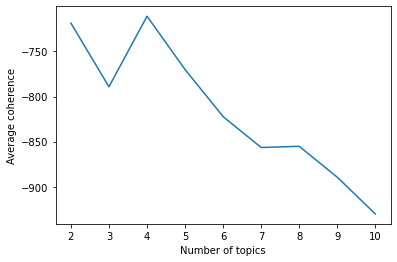

In [40]:
plt.plot(k_values, avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')

# For differnt number of topics, I fitted a different LDA



Text(0, 0.5, 'Average number of unique words')

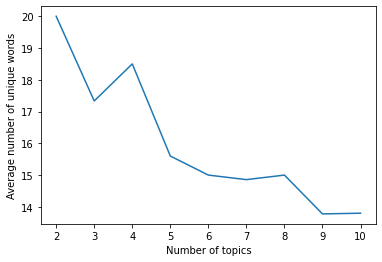

In [41]:
plt.plot(k_values, avg_num_unique_words)
plt.xlabel('Number of topics')
plt.ylabel('Average number of unique words')

# For different topic models, the average number of unique words
# We want coherence to be high and unique words to be high

# Number of topic = 2, gets me high coherence and hogh unique words. BUT, for model 2, there are 2 topics: garbage and not garbage!
# that doesnt help a lot

# So, you want to tolerate a lower value for one of the metrics, but look at the actual topics to interpret what is going on
# If we see resutlts of 4, starts to make more ssense but feels like still low
# go to 5, starts to make a bit more sense

